# Sliding pendulum system, with control

Consider the system composed of a simple pendulum of length $l$ and mass $m$ concentrated at its bob. The pivot of the pendulum is attached to a chariot of mass $m_o$ concentrated at its centre, sliding along a horizontal rail and submitted to a lateral control force field $\zeta$, possibly depending on time. The system is submitted to a uniform, constant gravitational acceleration field $g$ and moves without friction.

The generalised coordinate of the system is the position $x$ of the pivot on the rail and angle $\theta$ of the pendulum with the downward vertical direction. The standard (Cartesian) coordinates of the bob are then given by

\begin{equation*}
x_b = x+l\sin\theta
\hspace{2cm}
y_b = -l\cos\theta
\end{equation*}

The active forces are weight on the bob ($V_{(b)}=mgy$) and control on the pivot ($V_{(p)}=-\zeta x$). Hence the Lagrangian

\begin{eqnarray*}
\mathcal{L} & = & \frac{1}{2}(m_ox^2+m(\dot{x}^2+l^2\dot{\theta}^2+2l\dot{x}\dot{\theta}\cos\theta))+\zeta x+mgl\cos\theta\\
& = & \frac{1}{2}(m_o+m)\dot{x}^2+\frac{1}{2}m l^2\dot{\theta}^2+ml\dot{x}\dot{\theta}\cos\theta+\zeta x+mgl\cos\theta
\end{eqnarray*}

The equations of the dynamics are given by:

\begin{equation*}
\begin{array}{rrcl}
\left[\frac{\mathbf{d}}{\mathbf{d}t}\frac{\partial\mathcal{L}}{\partial\dot{x}} = \frac{\partial\mathcal{L}}{\partial x}\right]
\hspace{1cm} &
(m_o+m)\ddot{x}+ml\ddot{\theta}\cos\theta & = & \zeta+ml\dot{\theta}^2\sin\theta
\\
\left[\frac{\mathbf{d}}{\mathbf{d}t}\frac{\partial\mathcal{L}}{\partial\dot{\theta}} = \frac{\partial\mathcal{L}}{\partial\theta}\right]
\hspace{1cm} &
\ddot{x}\cos\theta+l\ddot{\theta} & = & -g\sin\theta
\end{array}
\end{equation*}

which can be rewritten as

\begin{equation*}
\left\{
\begin{array}{rcl}
a\ddot{x}+l\ddot{\theta}\cos\theta & = & u
\\
\ddot{x}\cos\theta+l\ddot{\theta} & = & v
\end{array}
\right.
\hspace{1cm}\textrm{where}\hspace{1cm}
\left|
\begin{array}{l}
a \triangleq 1+\frac{m_o}{m}
\\
u \triangleq \frac{\zeta}{m}+l\dot{\theta}^2\sin\theta
\hspace{1cm}
v \triangleq -g\sin\theta
\end{array}
\right.
\end{equation*}

The solution in $\ddot{x},\ddot{\theta}$ is therefore

\begin{equation*}
\left\{
\begin{array}{rcl}
\ddot{x} & = &
\frac{u-v\cos\theta}{a-\cos^2\theta}
\\
\ddot{\theta} & = &
\frac{av-u\cos\theta}{l(a-\cos^2\theta)}
\end{array}
\right.
\end{equation*}



Documentation: [here](../doc/_build/html/odesimu.html)

In [1]:
%pylab nbagg
# for better display performance, use default backend

import logging
logger = logging.getLogger()

from functools import partial
from scipy.integrate import quad
from ipyshow.odesimu.system import System, marker_hook
from ipyshow.odesimu.util import DPiecewiseFunc, buffered, blurred, logger_hook, PIDController

Populating the interactive namespace from numpy and matplotlib


## ControlledPendulum class

In [2]:
#----------------------------------------------------------------------------------------------------
class ControlledPendulum (System):
#----------------------------------------------------------------------------------------------------

    shadowshape = (2,)

    #integrator = dict(name='dopri5')
    integrator = dict(name='dop853')

    def __init__(self,control,Mo,M,L,G):
        self.Mo, self.M, self.L, self.G = Mo, M, L, G
        self.control = control
        def main(t,state,a=1+Mo/M):
            x,theta,dx,dtheta = state
            sintheta, costheta = sin(theta), cos(theta)
            u = control(t)[0]/M+L*square(dtheta)*sintheta
            v = -G*sintheta
            D = a-square(costheta)
            ddx = (u-v*costheta)/D
            ddtheta = (a*v-u*costheta)/(L*D)
            return array((dx,dtheta,ddx,ddtheta))
        self.main = main
        def fordisplay(state,a=1+Mo/M):
            x,theta,dx,dtheta = state
            live = x, (x+L*sin(theta), -L*cos(theta))
            return live, live[1]
        self.fordisplay = fordisplay

    Help = '''
        /Mo [kg]: mass of the chariot
        /M [kg]: mass of the bob
        /L [m]: length of pendulum
        /G [m.sec^-2]: gravitational acceleration
        /control: (lateral) control force field (instance of Controller class)
    '''

    def runstep(self,crate=None,ini=None,**ka):
        self.control.reset(ini)
        t0 = T = 1/crate
        for t,y in super(ControlledPendulum,self).runstep(ini=ini,**ka):
            if t>t0: self.control.update(t,y); t0 += T
            yield t,y

    def display(self,ax,refsize=60.,**ka):
        L = 4*self.L
        ax.set_ylim(-L,L)
        ax.set_xlim(-L,L)
        ax.axhline(0,c='k')
        mo,m = self.Mo,self.M
        r = clip(sqrt(mo/m),1./refsize,refsize)
        sz = (refsize*r,refsize/r)
        diag_l, = ax.plot((),(),'k')
        diag_s = ax.scatter((),(),s=sz,marker='o',c=('b','r'))
        tail_l, = ax.plot((),(),'y')
        ax.set_title(r'trajectory:cahotic')
        def disp(t,live,tail,L=2*self.L):
            x,(xb,yb) = live
            diag_l.set_data((x,xb),(0,yb))
            diag_s.set_offsets(((x,0),(xb,yb),))
            tail_l.set_data(tail[:,0],tail[:,1])
            xr = ax.get_xlim()
            if x>xr[1]: ax.set_xlim(xr[0]+L,xr[1]+L)
            elif x<xr[0]: ax.set_xlim(xr[0]-L,xr[1]-L)
        return super(ControlledPendulum,self).display(ax,disp,**ka)

    @staticmethod
    def makestate(x=0.,v=0.,theta=0.,w=0.):
        s = array((x,theta,v,w))
        s[2:] *= pi/180.
        return s

    Help += '''
        makestate/x [m]: position of the pivot
        makestate/v [m.sec^-1]: speed of the pivot
        makestate/theta [deg]: angle of the pendulum with downward vertical
        makestate/w [deg.sec^-1]: angular speed of pendulum
        launch/refsize: size in points^2 of the pendulum (bob and pivot), for display
        launch/crate: control rate
    '''

    launchdefaults = System.launchdefaults.copy()
    launchdefaults.update(
        taild=60,
        hooks=(partial(logger_hook,logger=logger),),
    )

    Help += System.Help

In [3]:
ControlledPendulum.helper()

In [4]:
PIDController.helper()

<IPython.core.display.Javascript object>


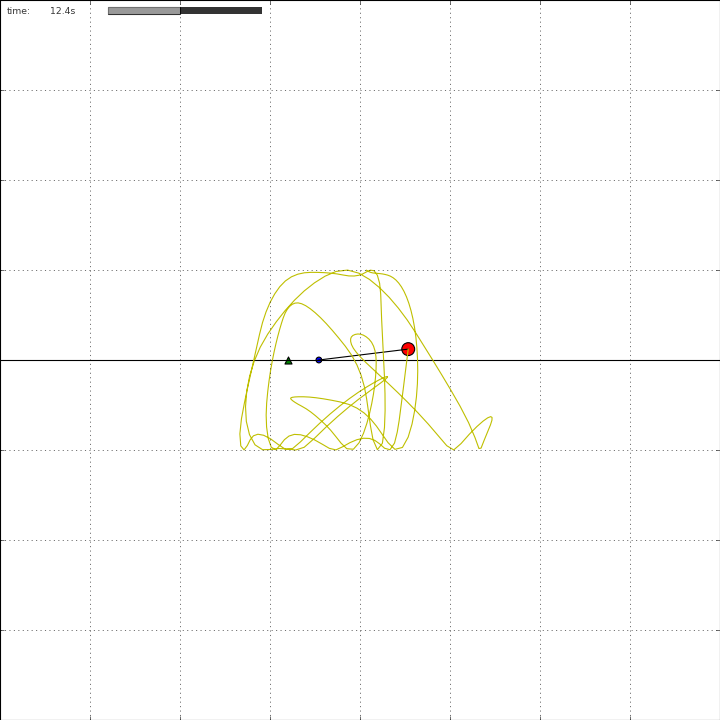

In [5]:
logger.setLevel(logging.WARNING) # can be changed dynamically by logger_hook

period=2
def sintarget(t,R=1.,omega=2*pi/period):
    p = omega*t
    return R*sin(p)
def sinsintarget(t,R=1.,k=3.,omega=2*pi/period):
    p = omega*t
    return R*sin(p)*sin(p/k)

#target = buffered(T=period,N=int(100*period))(partial(sintarget,R=3.))
target = buffered(T=period,N=int(100*period))(partial(sinsintarget,R=3.,k=10.5))
#target = lambda t: 0
control = PIDController(
    N=2,
    gP=6.,
    #gP=.5,
    #gI=1.,
    gD=10.,
    #gD=7.,
    target=blurred(0.,shape=(1,))(target),
    observe=(lambda state=zeros((4,)):state[:1]),
    )

syst = ControlledPendulum(control,Mo=1,M=5,L=2,G=9.81)
syst.launch(
    ini=syst.makestate(theta=179.,v=0.,w=0),
    crate=5.,
    hooks=(partial(marker_hook,f=(lambda t: (target(t),0.)),marker='^',s=40,c='g'),partial(logger_hook,logger=logger)),
    )